In [31]:
import numpy as np
import torch 

import dataset
import model
import utils
import attacks
import pickle

from importlib import reload
reload(utils)

import matplotlib.pyplot as plt
%matplotlib inline

import time

In [2]:
sphereset = dataset.sphere_dataset()

In [17]:
net1 = model.LargeReLU(sphere_dim=500,
                     n_hidden=2000)

### Sanity checks

1. For an arbitrary input, the model should output a number very close to zero, since it's the output of the final linear layer, which should be initialized with mean 0.

In [18]:
#Check for a single input at a time

idx = np.random.randint(0, len(sphereset))
print('Index: {}, Output: {}'.format(idx, net1(sphereset[idx][0])))

Index: 32201483, Output: tensor([-0.0004], grad_fn=<SqueezeBackward3>)


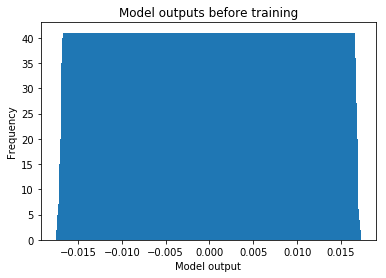

In [21]:
histogram_results = utils.histogram_outputs(net1, 500)
plt.bar(histogram_results[1], histogram_results[0], width = 1./30)
plt.xlabel('Model output')
plt.ylabel('Frequency')
# plt.xlim(-0.5,0.5)
plt.title('Model outputs before training');

2. Initially, the accuracy of the model should be a half.

In [22]:
utils.eval_accuracy(net1, n_pts=100)

0.57

## Training time

In [23]:
iteration = 2

loss_fun = torch.nn.BCEWithLogitsLoss()

batch_size = 50
dataloader = torch.utils.data.DataLoader(sphereset, 
                                         batch_size=batch_size,
                                         shuffle=False)

optimizer = torch.optim.Adam(net1.parameters(), lr = 0.00005)

net1.train()

losses = []

start_time = time.time()

checkpoint_steps = [10, 20,500, 1000, 2000, 3000, 4000, 5000, 10000, 100000] 

for i, (points, labels) in enumerate(dataloader):
    
    net1.zero_grad()
    
    output = net1(points)
    
    loss = loss_fun(output, labels.view(-1,1).float())
    loss.backward()
    
    optimizer.step()

    losses.append(loss.item())
    if i % 200 == 0:
        print("Iteration {}. Loss: {}".format(i, loss.item()))
    
    if i in checkpoint_steps:
        torch.save({'iteration': i, 
                    'model_state_dict': net1.state_dict(),
                    'loss': loss.item()}, 'trained_models/largeReLU_{}_{}.pth'.format(iteration, i))
    
    
    if i > 3000:
        break
    # should not be necessary, because the dataset only has 50 million images
    
print('Elapsed time: {}'.format(time.time() - start_time))

Iteration 0. Loss: 0.693134069442749
Iteration 200. Loss: 0.00045712123392149806
Iteration 400. Loss: 0.00018342006660532206
Iteration 600. Loss: 3.6092023947276175e-05
Iteration 800. Loss: 4.3339532567188144e-05
Iteration 1000. Loss: 0.0011115011293441057
Iteration 1200. Loss: 0.00026477209758013487
Iteration 1400. Loss: 0.000164827419212088
Iteration 1600. Loss: 8.225021156249568e-05
Iteration 1800. Loss: 5.5805408919695765e-05
Iteration 2000. Loss: 3.171533171553165e-05
Iteration 2200. Loss: 0.0023027800489217043
Iteration 2400. Loss: 5.978280751151033e-05
Iteration 2600. Loss: 3.328245657030493e-05
Iteration 2800. Loss: 1.1925478247576393e-05
Iteration 3000. Loss: 6.613666300836485e-06
Elapsed time: 300.9871129989624


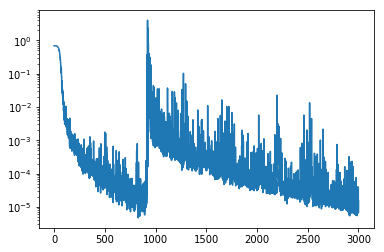

In [24]:
plt.semilogy(losses)

(array([117.,  89.,  70.,  54.,  48.,  38.,  30.,  25.,  20.,   9.]),
 array([0.06284542, 0.24984372, 0.43684202, 0.62384032, 0.81083862,
        0.99783693, 1.18483523, 1.37183353, 1.55883183, 1.74583013,
        1.93282843]),
 <a list of 10 Patch objects>)

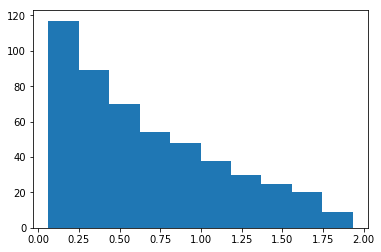

In [26]:
plt.hist(net1.alphas)

### More sanity checks

1. Accuracy should be a lot higher than 0.5 now

In [28]:
utils.eval_accuracy(net1, 1000000)

0.999994

2. Histogram should reveal two blobs, not one

Text(0.5,1,'Model outputs after training')

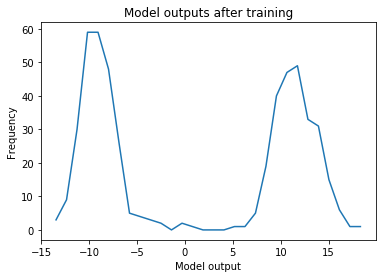

In [15]:
histogram_results = utils.histogram_outputs(net1, 500)
plt.plot(histogram_results[1], histogram_results[0])
plt.xlabel('Model output')
plt.ylabel('Frequency')
plt.title('Model outputs after training')

### Evaluating trained models

Error rates on both spheres (estimated from 100000 points):

* After 717766 training steps - 9e-5
* After 500 training steps - 3e-3
* After 1000 training steps - 3e-3
* After 2000 training steps - 1.7e-3
* After 3000 training steps - 1.3e-3
* After 4000 training steps - 5.9e-4
* After 5000 training steps - 6.4e-4
* After 10000 training steps - 5.8e-4
* After 100000 training steps - 2.7e-4

Error rates on the inner sphere only (estimated from 1 million points):
* After 10 training steps - 1.7e-4
* After 500 training steps - 1.5e-4
* After 1000 training steps - 1.6e-4
* After 2000 training steps - 1.6e-4
* After 3000 training steps - 1.7e-4
* After 4000 training steps - 1.6e-4
* After 5000 training steps - 1.3e-4
* After 10000 training steps - 1.4e-4
* After 100000 training steps - 1.6e-4
* After 717766 training steps - 1.5e-4

In [153]:
models_to_load = checkpoint_steps + [717766]

model_errs = {}

for model_num in models_to_load:

    test_net = model.LargeReLU(sphere_dim=500,
                     n_hidden=1000)

    loaded_parms = torch.load('trained_models/largeReLU_{}_{}.pth'.format(1, model_to_load))
    test_net.load_state_dict(loaded_parms['model_state_dict'])
    
    model_errs[model_num] = 1 - utils.eval_accuracy_single(test_net, 1000000, radius=1, desired_label=0)

### Attacking the model

In [158]:
model_to_load = 500

test_net = model.LargeReLU(sphere_dim=500,
                 n_hidden=1000)

loaded_parms = torch.load('trained_models/largeReLU_{}_{}.pth'.format(1, model_to_load))
test_net.load_state_dict(loaded_parms['model_state_dict'])

In [236]:
dset = dataset.single_sphere_dataset()

test_idx = 0
test_point = dset[test_idx]

In [237]:
perturbed_point = attacks.projected_GD(test_net, test_point, 0, max_iter=10000, verbose=True)

Iter 0, loss 0.0009934734553098679
Iter 100, loss 0.0011121999705210328
Iter 200, loss 0.0012761552352458239
Iter 300, loss 0.0015628041001036763
Iter 400, loss 0.00226788641884923
Iter 500, loss 0.015628362074494362


In [231]:
test_net(perturbed_point)

tensor([6.0343], grad_fn=<SqueezeBackward3>)

In [ ]:
dist = attacks.avg_distance_to_errorset(test_net,
                                 radius=1,
                                 correct_classification=0,
                                 n_pts=100,
                                 max_iter=10000)

Iter 0, loss 0.0002809368306770921
Iter 100, loss 0.0002862997353076935
Iter 200, loss 0.0002917817619163543
Iter 300, loss 0.00029762129997834563
Iter 400, loss 0.000303818320389837
Iter 500, loss 0.0003104920033365488
Iter 600, loss 0.00031740395934320986
Iter 700, loss 0.000324673397699371
Iter 800, loss 0.0003325386205688119
Iter 900, loss 0.0003408804477658123
Iter 1000, loss 0.00034981805947609246
Iter 1100, loss 0.0003594706067815423
Iter 1200, loss 0.00036971885128878057
Iter 1300, loss 0.00038092033355496824
Iter 1400, loss 0.00039307496626861393
Iter 1500, loss 0.000406301929615438
Iter 1600, loss 0.00042083943844772875
Iter 1700, loss 0.0004368066438473761
Iter 1800, loss 0.00045468006283044815
Iter 1900, loss 0.00047469791024923325
Iter 2000, loss 0.0004970983718521893
Iter 2100, loss 0.0005222387262620032
Iter 2200, loss 0.0005504761938937008
Iter 2300, loss 0.0005822870298288763
Iter 2400, loss 0.0006188622792251408
Iter 2500, loss 0.0006613928126171231
Iter 2600, loss 0.

Iter 300, loss 0.000812915270216763
Iter 400, loss 0.0008859285153448582
Iter 500, loss 0.0009773960337042809
Iter 600, loss 0.0010987442219629884
Iter 700, loss 0.0012679402716457844
Iter 800, loss 0.001549235312268138
Iter 900, loss 0.00225623045116663
Iter 1000, loss 0.021913422271609306
Iter 0, loss 0.00020215852418914437
Iter 100, loss 0.00020418466010596603
Iter 200, loss 0.00020632999076042324
Iter 300, loss 0.00020859450160060078
Iter 400, loss 0.0002108589978888631
Iter 500, loss 0.0002131234941771254
Iter 600, loss 0.00021562635083682835
Iter 700, loss 0.00021801002731081098
Iter 800, loss 0.00022063204960431904
Iter 900, loss 0.0002232540718978271
Iter 1000, loss 0.00022599527437705547
Iter 1100, loss 0.00022885564249008894
Iter 1200, loss 0.0002317160106031224
Iter 1300, loss 0.0002348147245356813
Iter 1400, loss 0.0002379134384682402
Iter 1500, loss 0.00024125049822032452
Iter 1600, loss 0.0002445875434204936
Iter 1700, loss 0.00024816294899210334
Iter 1800, loss 0.0002517

Iter 8000, loss 0.0002530493075028062
Iter 8100, loss 0.0002557904226705432
Iter 8200, loss 0.0002585315378382802
Iter 8300, loss 0.0002613918040879071
Iter 8400, loss 0.0002643712505232543
Iter 8500, loss 0.0002674698771443218
Iter 8600, loss 0.0002706876548472792
Iter 8700, loss 0.0002739054325502366
Iter 8800, loss 0.00027736154152080417
Iter 8900, loss 0.00028081765049137175
Iter 9000, loss 0.00028451209072954953
Iter 9100, loss 0.0002882065309677273
Iter 9200, loss 0.00029213930247351527
Iter 9300, loss 0.000296310376143083
Iter 9400, loss 0.00030048147891648114
Iter 9500, loss 0.0003047717036679387
Iter 9600, loss 0.0003093002596870065
Iter 9700, loss 0.00031394799589179456
Iter 9800, loss 0.00031883400515653193
Iter 9900, loss 0.0003238391946069896
Iter 0, loss 0.00042524831951595843
Iter 100, loss 0.0004383556661196053
Iter 200, loss 0.0004524161049630493
Iter 300, loss 0.0004676678800024092
Iter 400, loss 0.0004844683862756938
Iter 500, loss 0.0005030558677390218
Iter 600, los

Iter 3000, loss 0.00013779645087197423
Iter 3100, loss 0.00013851160474587232
Iter 3200, loss 0.0001392267586197704
Iter 3300, loss 0.0001399419124936685
Iter 3400, loss 0.00014053787162993103
Iter 3500, loss 0.00014125302550382912
Iter 3600, loss 0.0001419681793777272
Iter 3700, loss 0.0001426833332516253
Iter 3800, loss 0.00014351768186315894
Iter 3900, loss 0.00014423283573705703
Iter 4000, loss 0.00014494798961095512
Iter 4100, loss 0.0001456631434848532
Iter 4200, loss 0.00014649749209638685
Iter 4300, loss 0.0001472126314183697
Iter 4400, loss 0.00014804698002990335
Iter 4500, loss 0.00014888131408952177
Iter 4600, loss 0.00014959646796341985
Iter 4700, loss 0.00015043080202303827
Iter 4800, loss 0.0001512651506345719
Iter 4900, loss 0.00015209948469419032
Iter 5000, loss 0.00015293381875380874
Iter 5100, loss 0.00015376816736534238
Iter 5200, loss 0.00015472168161068112
Iter 5300, loss 0.00015555603022221476
Iter 5400, loss 0.0001565095444675535
Iter 5500, loss 0.000157343878527

Iter 1900, loss 0.0001938155182870105
Iter 2000, loss 0.00019560330838430673
Iter 2100, loss 0.00019751029321923852
Iter 2200, loss 0.00019941726350225508
Iter 2300, loss 0.00020144341397099197
Iter 2400, loss 0.00020358874462544918
Iter 2500, loss 0.0002057340752799064
Iter 2600, loss 0.00020787939138244838
Iter 2700, loss 0.0002101439022226259
Iter 2800, loss 0.00021252757869660854
Iter 2900, loss 0.0002150304353563115
Iter 3000, loss 0.00021753329201601446
Iter 3100, loss 0.00022003613412380219
Iter 3200, loss 0.0002227773511549458
Iter 3300, loss 0.00022551853908225894
Iter 3400, loss 0.00022837892174720764
Iter 3500, loss 0.00023135847004596144
Iter 3600, loss 0.0002343380037928
Iter 3700, loss 0.0002374367177253589
Iter 3800, loss 0.0002406545972917229
Iter 3900, loss 0.00024399164249189198
Iter 4000, loss 0.0002474478678777814
Iter 4100, loss 0.00025102324434556067
Iter 4200, loss 0.0002547178009990603
Iter 4300, loss 0.0002586507180240005
Iter 4400, loss 0.0002627027570270002
I

Iter 3700, loss 0.00018439977429807186
Iter 3800, loss 0.00018571082910057157
Iter 3900, loss 0.00018702188390307128
Iter 4000, loss 0.000188332938705571
Iter 4100, loss 0.00018988236843142658
Iter 4200, loss 0.00019131260341964662
Iter 4300, loss 0.00019274283840786666
Iter 4400, loss 0.00019429226813372225
Iter 4500, loss 0.0001958416833076626
Iter 4600, loss 0.00019751029321923852
Iter 4700, loss 0.00019905969384126365
Iter 4800, loss 0.00020072828920092434
Iter 4900, loss 0.00020251607929822057
Iter 5000, loss 0.00020418466010596603
Iter 5100, loss 0.00020597243565134704
Iter 5200, loss 0.00020776021119672805
Iter 5300, loss 0.00020954797219019383
Iter 5400, loss 0.00021145492792129517
Iter 5500, loss 0.00021336186910048127
Iter 5600, loss 0.0002153879904653877
Iter 5700, loss 0.00021741411183029413
Iter 5800, loss 0.0002195594133809209
Iter 5900, loss 0.0002217047003796324
Iter 6000, loss 0.00022384998737834394
Iter 6100, loss 0.00022623363474849612
Iter 6200, loss 0.0002284981019

Iter 1700, loss 0.00027938754647038877
Iter 1800, loss 0.0002826052950695157
Iter 1900, loss 0.00028606137493625283
Iter 2000, loss 0.00028951745480298996
Iter 2100, loss 0.0002932118659373373
Iter 2200, loss 0.00029690624796785414
Iter 2300, loss 0.00030071981018409133
Iter 2400, loss 0.0003047717036679387
Iter 2500, loss 0.00030882356804795563
Iter 2600, loss 0.0003131137927994132
Iter 2700, loss 0.0003175231395289302
Iter 2800, loss 0.00032217081752605736
Iter 2900, loss 0.0003270567976869643
Iter 3000, loss 0.00033206192892976105
Iter 3100, loss 0.000337305391440168
Iter 3200, loss 0.00034278715611435473
Iter 3300, loss 0.00034850722295232117
Iter 3400, loss 0.00035446559195406735
Iter 3500, loss 0.0003607814433053136
Iter 3600, loss 0.0003673355677165091
Iter 3700, loss 0.00037424711626954377
Iter 3800, loss 0.0003815161471720785
Iter 3900, loss 0.00038926175329834223
Iter 4000, loss 0.00039736481267027557
Iter 4100, loss 0.0004058252670802176
Iter 4200, loss 0.0004146431456319988

Iter 1100, loss 0.0033033110667020082
Iter 0, loss 0.0012309125158935785
Iter 100, loss 0.0014422263484448195
Iter 200, loss 0.0017889224691316485
Iter 300, loss 0.002719872398301959
Iter 0, loss 0.0024103655014187098
Iter 0, loss 0.0003779412363655865
Iter 100, loss 0.0003885467885993421
Iter 200, loss 0.0003999863693024963
Iter 300, loss 0.00041237910045310855
Iter 400, loss 0.00042572495294734836
Iter 500, loss 0.000440262199845165
Iter 600, loss 0.00045599075383506715
Iter 700, loss 0.00047302976599894464
Iter 800, loss 0.0004919749335385859
Iter 900, loss 0.0005133026279509068
Iter 1000, loss 0.0005368936690501869
Iter 1100, loss 0.000563224486541003
Iter 1200, loss 0.0005927712772972882
Iter 1300, loss 0.0006260104128159583
Iter 1400, loss 0.0006644901586696506
Iter 1500, loss 0.0007095203618519008
Iter 1600, loss 0.0007640779949724674
Iter 1700, loss 0.0008305437513627112
Iter 1800, loss 0.0009127265075221658
Iter 1900, loss 0.001019673072732985
Iter 2000, loss 0.001165664056316

Iter 3300, loss 0.0010519453790038824
Iter 3400, loss 0.0012001938885077834
Iter 3500, loss 0.0014211564557626843
Iter 3600, loss 0.0018542492762207985
Iter 3700, loss 0.0033001031260937452
Iter 0, loss 0.0010870745172724128
Iter 100, loss 0.0012687736889347434
Iter 200, loss 0.0015975582646206021
Iter 300, loss 0.0025548457633703947
Iter 0, loss 0.0003002431185450405
Iter 100, loss 0.0003067976504098624
Iter 200, loss 0.0003137096355203539
Iter 300, loss 0.00032085992279462516
Iter 400, loss 0.00032860602368600667
Iter 500, loss 0.0003367095487192273
Iter 600, loss 0.00034540885826572776
Iter 700, loss 0.00035470392322167754
Iter 800, loss 0.00036459474358707666
Iter 900, loss 0.00037520044133998454
Iter 1000, loss 0.000386640167562291
Iter 1100, loss 0.0003987947420682758
Iter 1200, loss 0.0004120216181036085
Iter 1300, loss 0.0004262015863787383
Iter 1400, loss 0.0004413345886860043
Iter 1500, loss 0.0004580163804348558
Iter 1600, loss 0.0004764852055814117
Iter 1700, loss 0.0004973

Iter 1900, loss 0.000925112864933908
Iter 2000, loss 0.0010318199638277292
Iter 2100, loss 0.0011739989276975393
Iter 2200, loss 0.0013823487097397447
Iter 2300, loss 0.0017848765710368752
Iter 2400, loss 0.00304758595302701
Iter 0, loss 0.00040880427695810795
Iter 100, loss 0.0004203628050163388
Iter 200, loss 0.00043275527423247695
Iter 300, loss 0.00044610086479224265
Iter 400, loss 0.00046039948938414454
Iter 500, loss 0.0004757702990900725
Iter 600, loss 0.0004924515378661454
Iter 700, loss 0.0005104430601932108
Iter 800, loss 0.0005302215577103198
Iter 900, loss 0.0005521441926248372
Iter 1000, loss 0.000576449150685221
Iter 1100, loss 0.0006042085005901754
Iter 1200, loss 0.0006354220095090568
Iter 1300, loss 0.000671042304020375
Iter 1400, loss 0.0007115454645827413
Iter 1500, loss 0.0007591941393911839
Iter 1600, loss 0.000816250394564122
Iter 1700, loss 0.0008844992844387889
Iter 1800, loss 0.0009666775586083531
Iter 1900, loss 0.0010714748641476035
Iter 2000, loss 0.00121043

## Train several models

In [62]:
model_types = ['large']
num_repeats = 2

loss_fun = torch.nn.BCEWithLogitsLoss()
batch_size = 200

max_training_iter = 100000

for model_type in model_types:
    for repeat_num in range(num_repeats):
        if model_type == 'large':
            net1 = model.LargeReLU(sphere_dim=500, n_hidden=2000)
        elif model_type == 'small':
            net1 = model.SmallReLU(sphere_dim=500, n_hidden=1000)
        
        optimizer = torch.optim.Adam(net1.parameters(), lr = 0.000001)

        dataloader = torch.utils.data.DataLoader(sphereset, 
                                                 batch_size=batch_size,
                                                 shuffle=False)

        net1.train()

        losses = np.zeros(max_training_iter+1)

        checkpoint_steps = [10, 20,500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 99999] 

        for i, (points, labels) in enumerate(dataloader):

            net1.zero_grad()

            output = net1(points)

            loss = loss_fun(output, labels.view(-1,1).float())
            loss.backward()

            optimizer.step()

            losses[i] = loss.item()

            if i in checkpoint_steps:
                torch.save({'iteration': i, 
                            'model_state_dict': net1.state_dict(),
                            'loss': loss.item()}, 'trained_models/{}ReLU_{}_{}.pth'.format(model_type, repeat_num, i))


            if i >= max_training_iter:
                break
            # should not be necessary, because the dataset only has 50 million images
            
        with open('trained_models/Losses_{}ReLU_{}.pickle'.format(model_type, repeat_num), 'wb') as f:
            pickle.dump(losses, f)
            

In [63]:
d = {}
for i in [0,1]:
    with open('trained_models/Losses_largeReLU_{}.pickle'.format(i), 'rb') as f:
        d[i] = pickle.load(f)

(1e-12, 0.01)

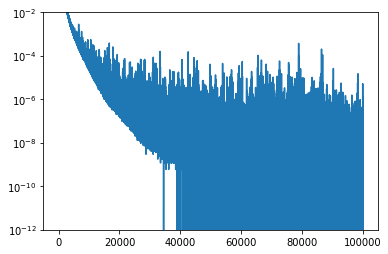

In [69]:
# plt.semilogy(d[0])
plt.semilogy(d[1])
plt.ylim(1e-12,1e-2)

## Loading and evaluating a trained model

In [72]:
start = time.time()

test_net = model.LargeReLU(sphere_dim=500,
                     n_hidden=2000)



loaded_parms = torch.load('trained_models/largeReLU_{}_{}.pth'.format(0, 99999))
test_net.load_state_dict(loaded_parms['model_state_dict'])

load_time = time.time()

print(1 - utils.eval_accuracy_single(test_net, 1000000, radius=1, desired_label=0))

end_time = time.time()

0.0


In [75]:
end_time - start

141.36570644378662